In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm
import GraphHelpers as GH

In [2]:
#Read in data
RawData=pd.read_csv('.\RawDatafiles\RainShelterBeta_Energy.dat.gz', #specify file path for data to read in
                         compression = 'gzip',  #file is ziped
                         parse_dates=True, #tell the function to parse date columns to datetime formats
                         dayfirst=True, #tell the function that the day is before the year in the data i.e format='%d/%m/%Y %H:%M'
                         skiprows = [0,2,3], #leave out rows 1, 3 and 4 which have redundant information
                         index_col = 0, #Use the first column, which is Date, as an index
                         na_values = 'NAN')

## Check index for duplicates

In [3]:
seen = {}
dupes = []

for x in RawData.index:
    if x not in seen:
        seen[x] = 1
    else:
        if seen[x] == 1:
            dupes.append(x)
        seen[x] += 1
dupes

[]

## No duplicates = good

In [4]:
#Bring in index data
DataIndex=pd.read_excel('.\IndexFiles\RadiationAndTempIndex.xlsx', 
                        sheet_name='Sensor positions',
                        usecols = range(9))
DataIndex.set_index('ColumnHeader',inplace=True)
# #Apply indexes to data
DataTransposed = RawData.transpose() 
DataIndexed = pd.concat([DataIndex,DataTransposed], axis=1,sort=False)
DataIndexed.index.name='ColumnHeader'
DataIndexed.set_index(['Measurement','Irrigation','Nitrogen','Treatment','Units','Summary','Plot','Block'], 
                         append=False, inplace=True)
Data=DataIndexed.transpose()
Data.index = pd.to_datetime(Data.index)  ## for some reason the concat function changes the data type on the date indes so need to change it back
Data = Data.drop(columns='Time',level=0) ## Drop blank time column
Data.sort_index(inplace=True)
Data.sort_index(axis=1,inplace=True)

## Set up Graphics Patterns

In [5]:
GPs = GH.SetGraphicsPatterns(Data.IR_SurfaceTemp.columns,
                    ['-','--'],
                    [0.15,0.45],
                    ['o','^'],
                    ['orange','green','purple'])

Start = Data.index.min()
End = Data.index.max()

Irrigation
['Excess', 'Normal']
Nitrogen
['125', '320', '80']
Treatments
MultiIndex(levels=[['Excess', 'Normal'], ['125', '320', '80']],
           labels=[[0, 0, 0, 1, 1, 1], [0, 1, 2, 0, 1, 2]])
Styles
[('-', 'orange', 0.15, 'o'), ('-', 'green', 0.15, 'o'), ('-', 'purple', 0.15, 'o'), ('--', 'orange', 0.45, '^'), ('--', 'green', 0.45, '^'), ('--', 'purple', 0.45, '^')]
StyleFrame
           Lin     Col   Alp Mar     MFC
Excess 125   -  orange  0.15   o  orange
       320   -   green  0.15   o   green
       80    -  purple  0.15   o  purple
Normal 125  --  orange  0.45   ^   white
       320  --   green  0.45   ^   white
       80   --  purple  0.45   ^   white


### Work out how long our date series in in weeks

In [6]:
from datetime import timedelta #Import function needed for doing date deltas 
FirstMeasurement  = Data.index.min(axis=0)
LastMeasurement = Data.index.max(axis=0)
Duration = (LastMeasurement - FirstMeasurement)/timedelta(weeks=1)
ExptDuration = np.round(Duration,decimals=0) #weeks
ExptDuration

22.0

### Graph data in two weekly blocks to see how it looks

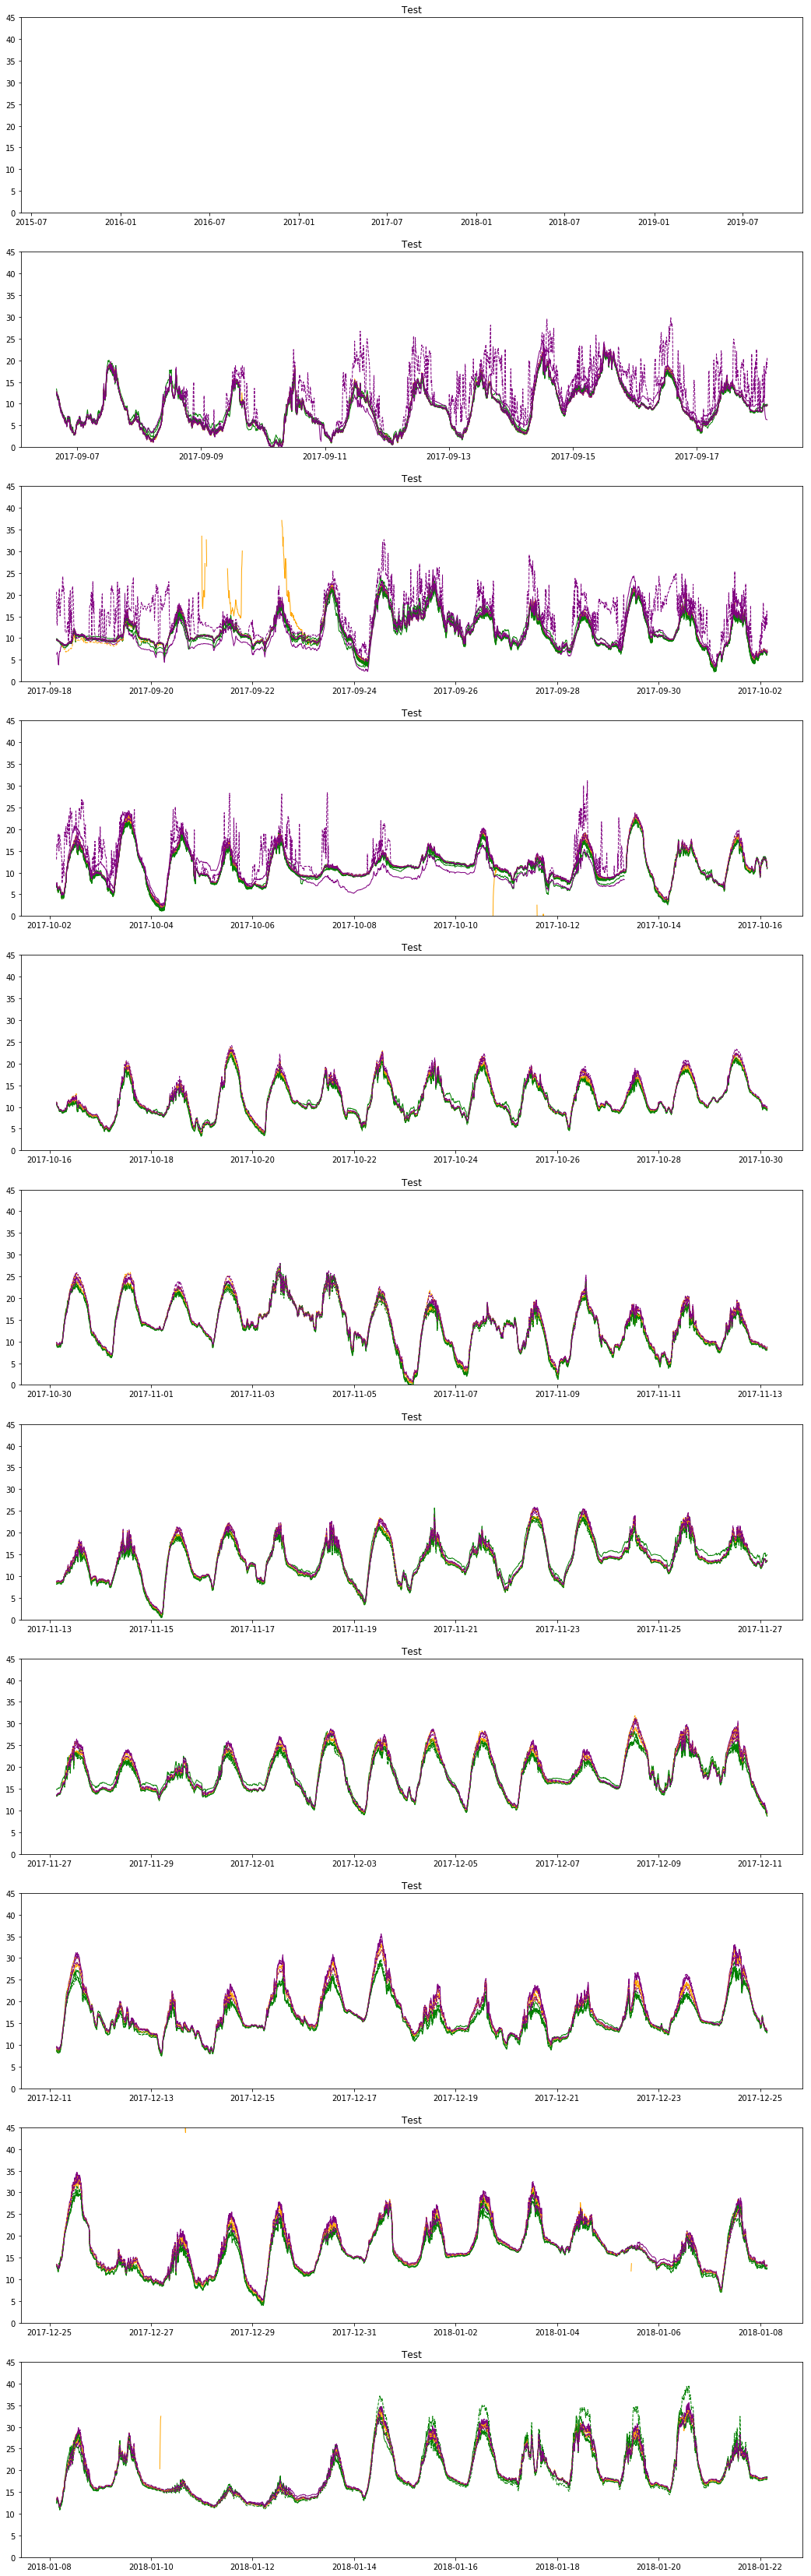

In [7]:
def MakeGraph(DataFrame,ymax,ymin):
    PlotDuration = 2
    Pannels = np.int(ExptDuration/PlotDuration)
    #Create a figure object
    for X in range (0,Pannels):
        if (X == 0):
            StartDate = Data.index.min(axis=0)  #Set start of series at start of data
        else: 
            StartDate = StartDate + timedelta(weeks=PlotDuration)    #increment start date by a week
        StartDateString = StartDate.strftime("%Y-%m-%d")  #Turn this to a string
        EndDate = StartDate + timedelta(weeks=PlotDuration)       #Set start date the specified duration before the end date 
        EndDateString = EndDate.strftime("%Y-%m-%d")           #Turn that into a string
        Position = X+1;
        ax = Fig.add_subplot(Pannels,1,Position)
        GH.AddIndexedPlot(DataFrame.loc[StartDate:EndDate,:],ax,GPs,1)
        plt.title('Test', fontsize=12);
        plt.ylim(ymin,ymax)
        
Fig = plt.figure(figsize=(18, 60))
MakeGraph(Data.IR_SurfaceTemp,45,-0)

### Some of the sensors have problems.  Check the sensor body temperature reference to work out why

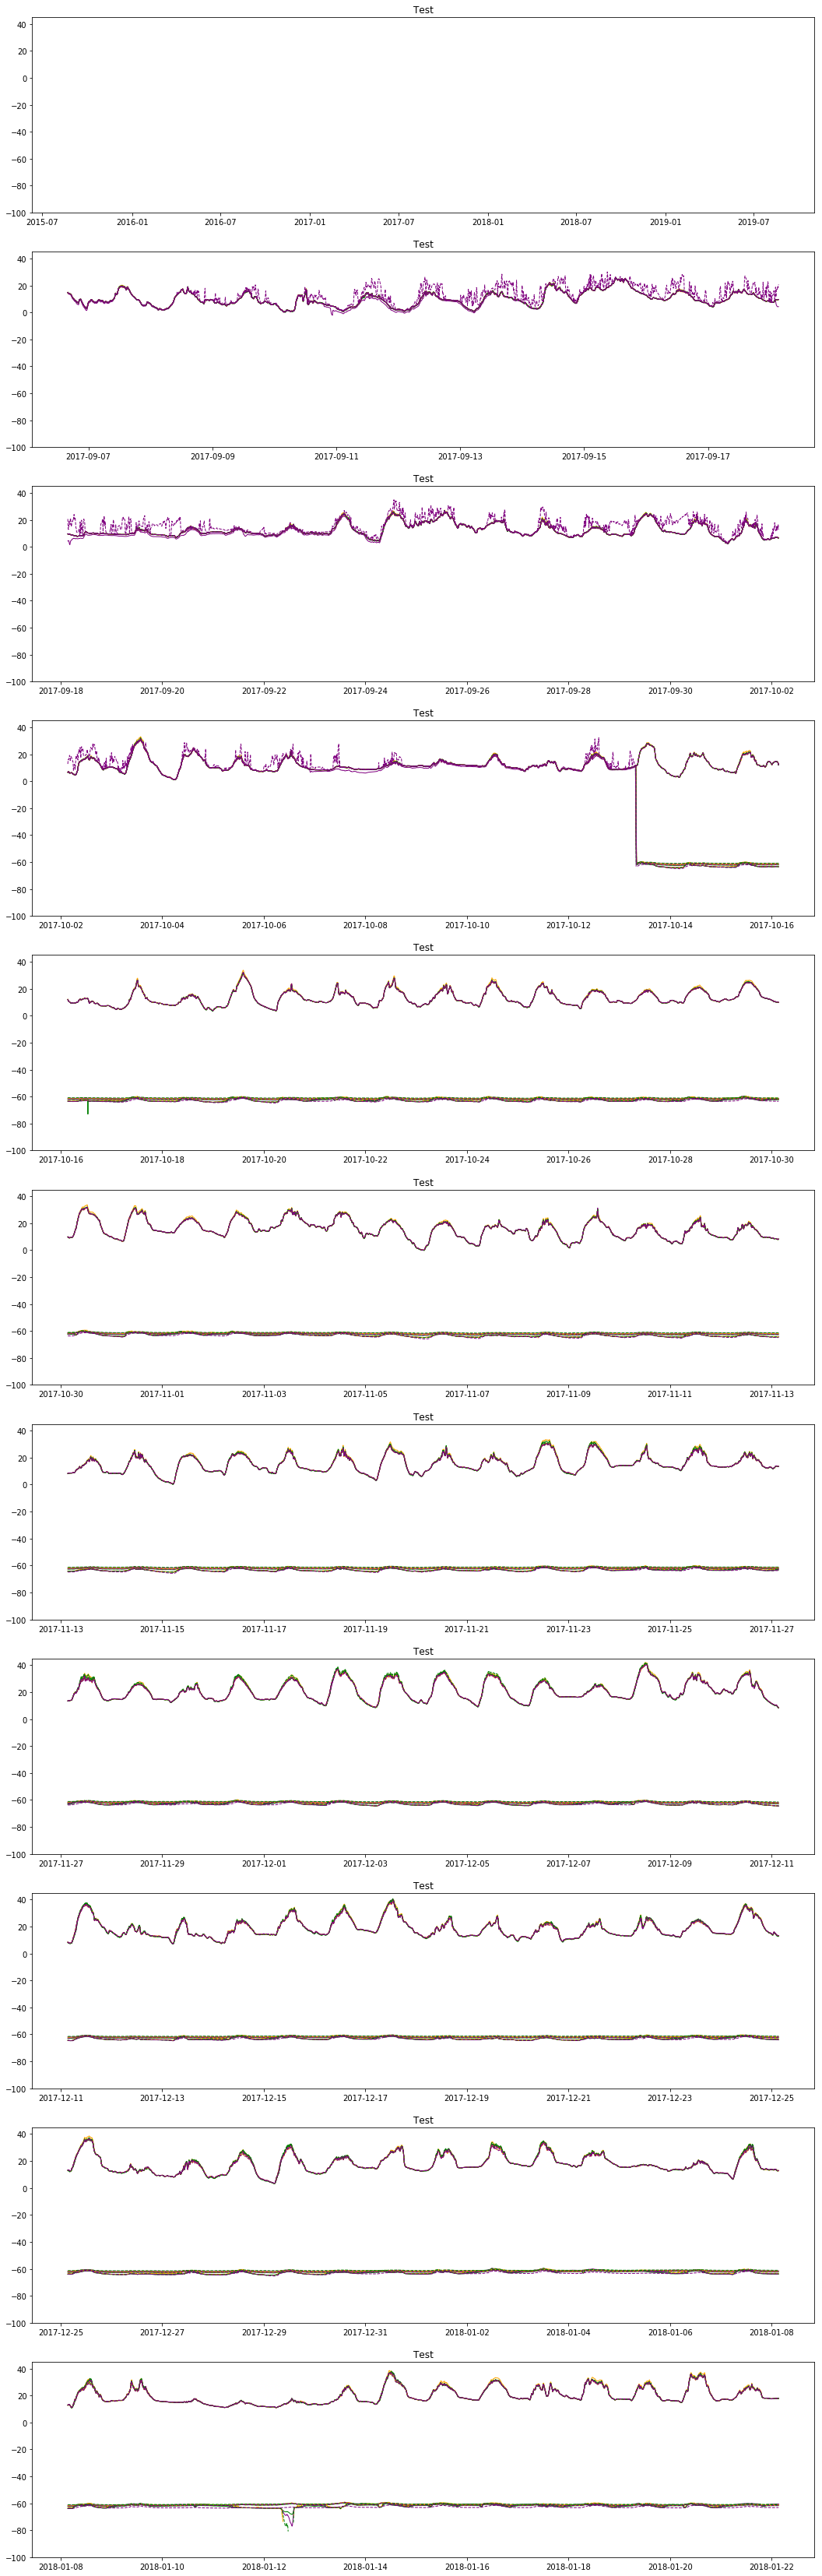

In [8]:
Fig = plt.figure(figsize=(18, 60))
MakeGraph(Data.IR_SensorBodyTemp,45,-100)

### There are problems with a few sensors which appears to be comming from problems with body temperature referece.  Need to identify this and drop the offending data

In [9]:
Data.loc[:,('IR_SurfaceTemp','Normal','80',slice(None),slice(None),slice(None),101)] =  np.nan
Data.loc[:,('IR_SurfaceTemp','Excess','125',slice(None),slice(None),slice(None),109)] =  np.nan
Data.loc[:,('IR_SurfaceTemp','Excess','80',slice(None),slice(None),slice(None),120)] =  np.nan

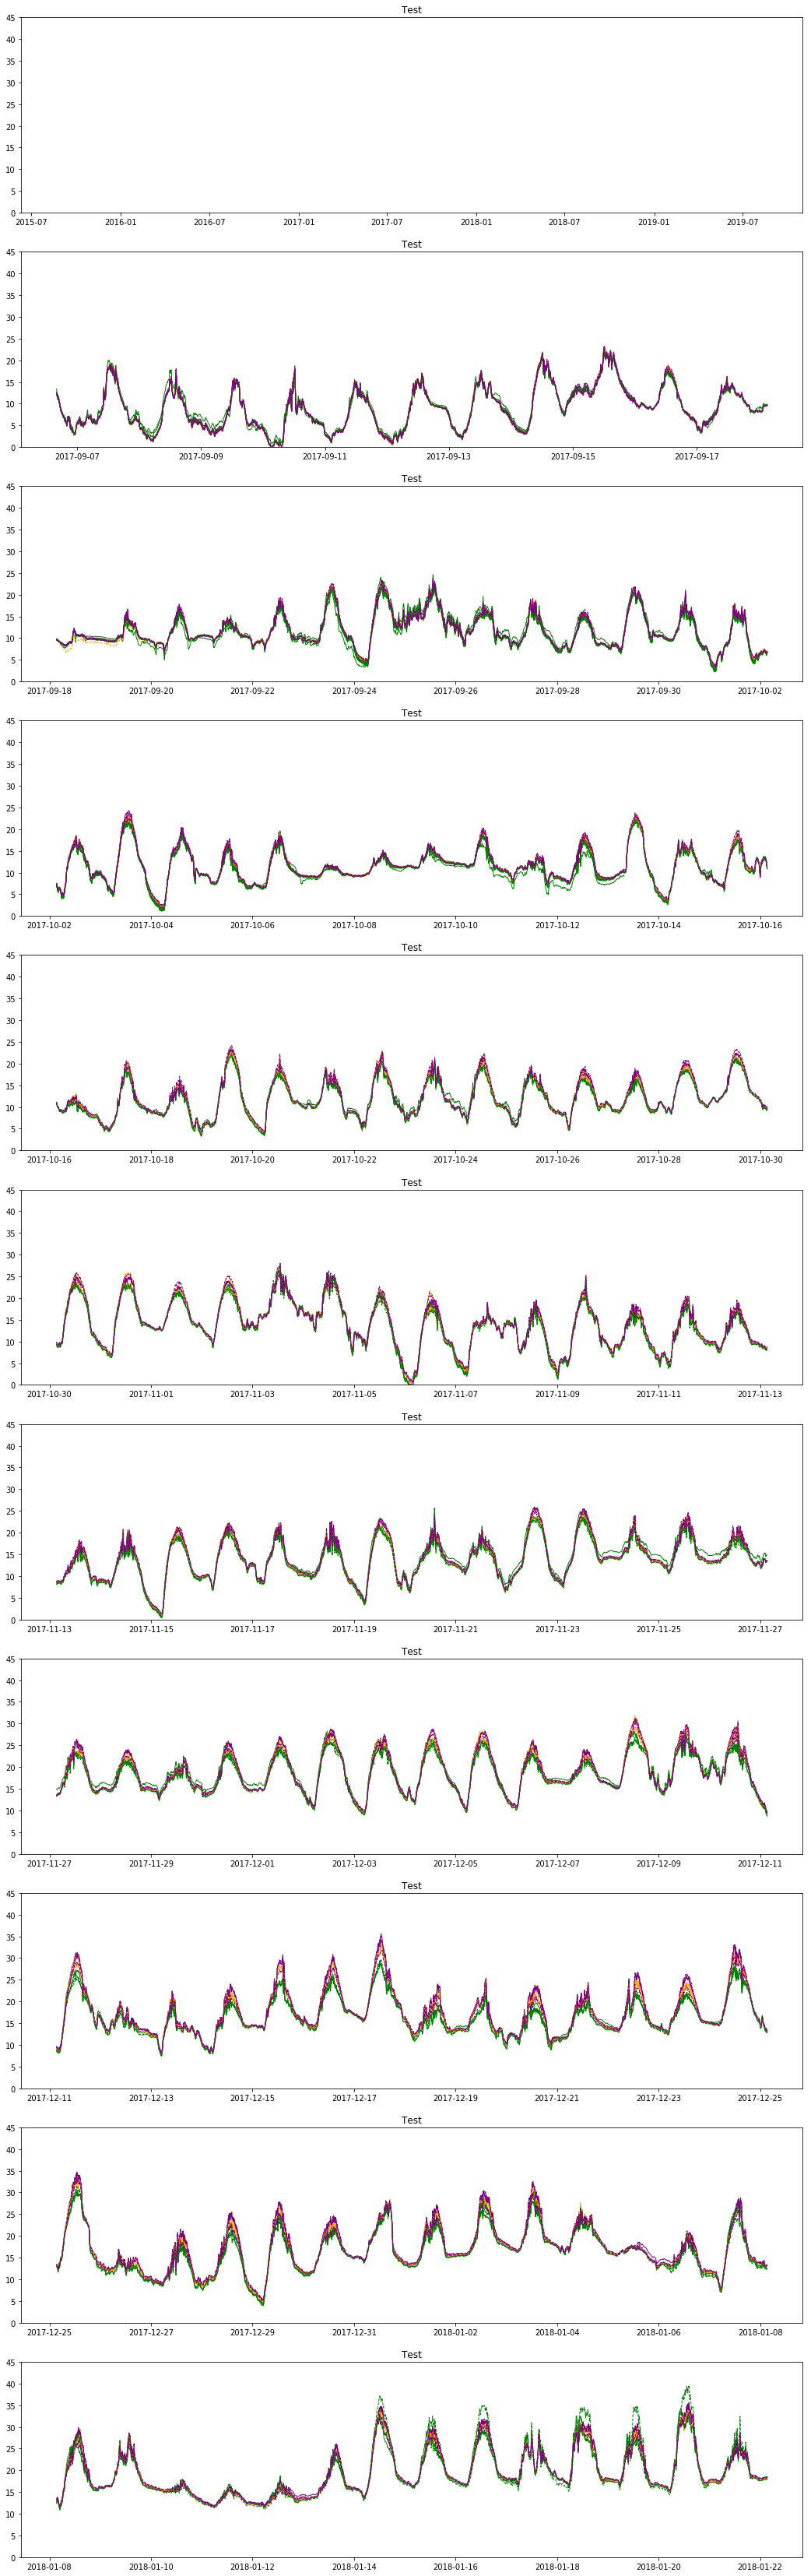

In [10]:
#Create a figure object
Fig = plt.figure(figsize=(18, 60))
MakeGraph(Data.IR_SurfaceTemp,45,0)

### remove large errant values

In [11]:
def bound(x,up,low):
    if x < low or x > up:
        return np.nan
    else:
        return x
for col in Data.loc[:,'IR_SurfaceTemp'].columns:
    Data.loc[:,('IR_SurfaceTemp',)+col] = [bound(Data.loc[x,('IR_SurfaceTemp',)+col],60,-10) for x in Data.index]

## Data looks OK to progress with now

# Now lets look at soil temp

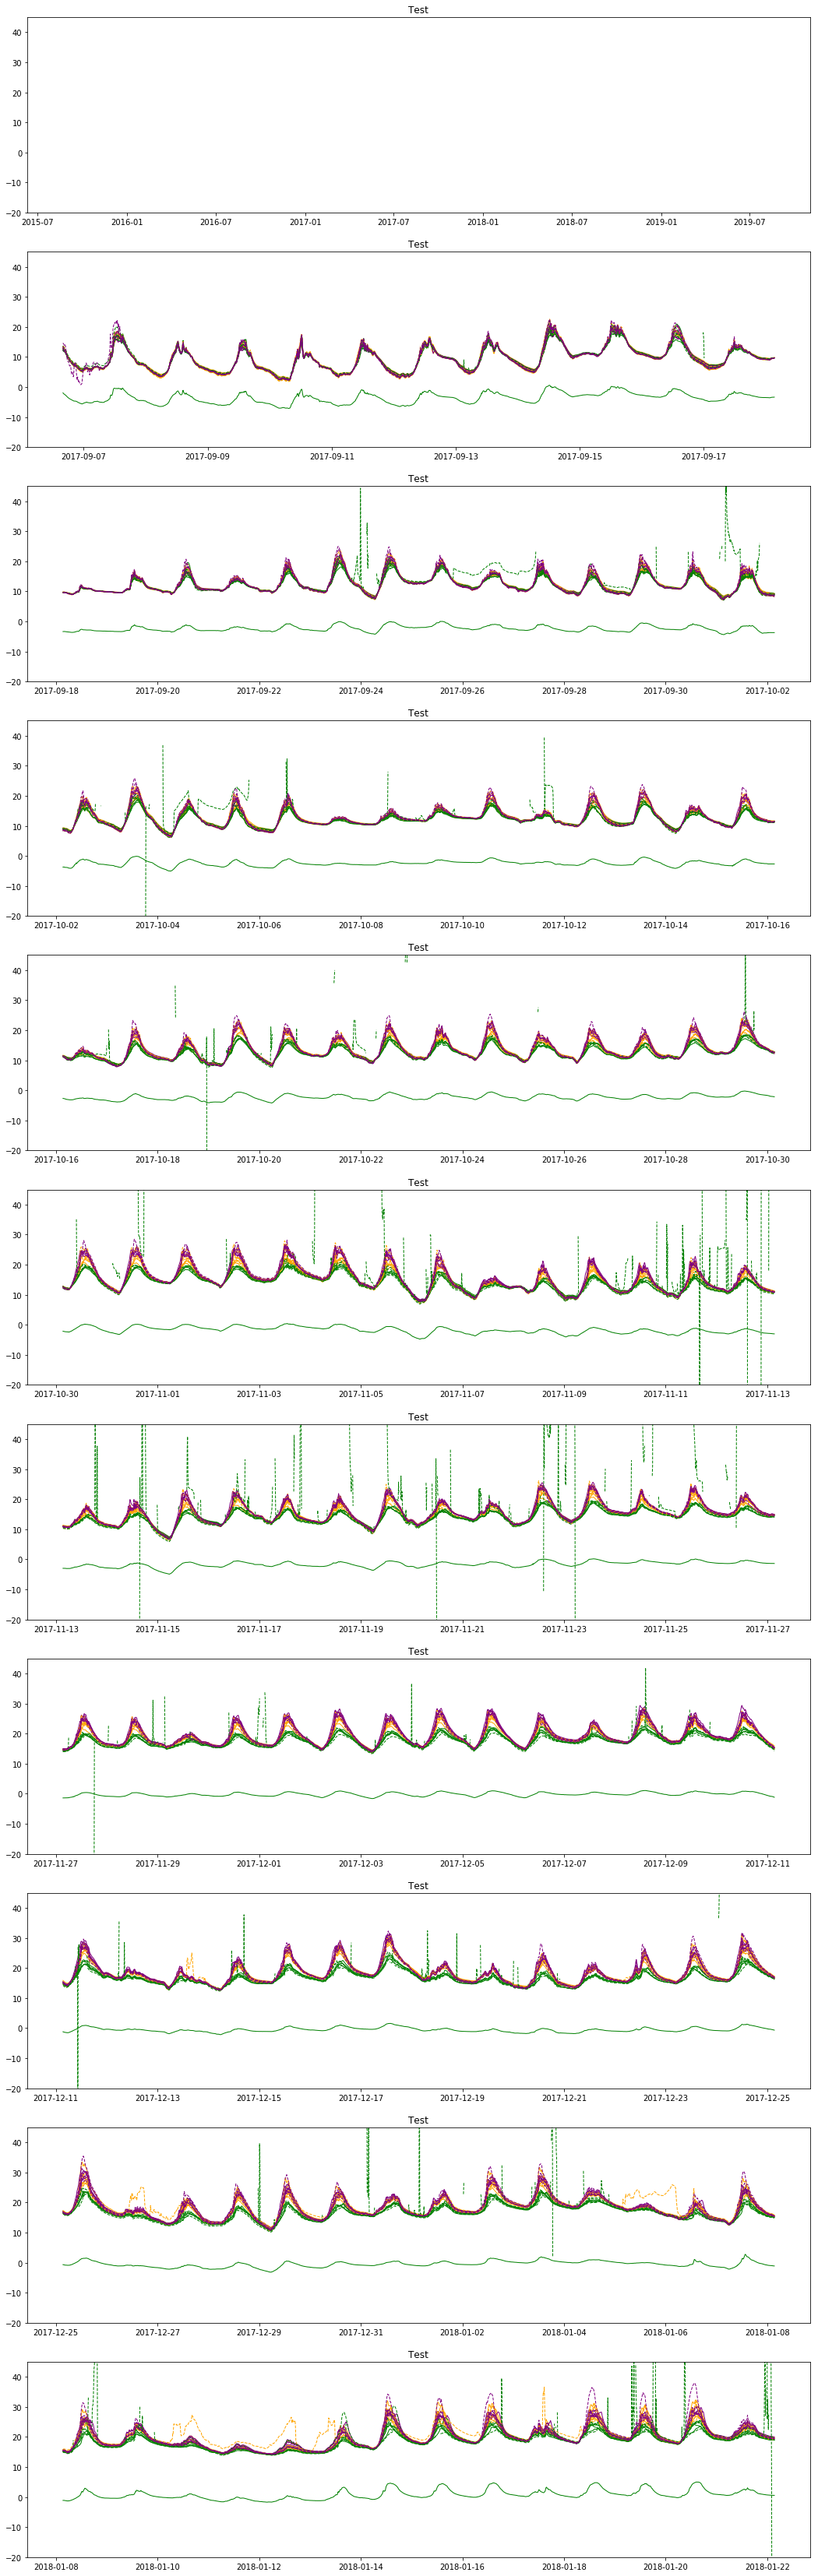

In [12]:
#Create a figure object
Fig = plt.figure(figsize=(18, 60))
MakeGraph(Data.SurfaceSoilTemp,45,-20)

## Some problems, will fix later if I need this data

## Check reflected radiation

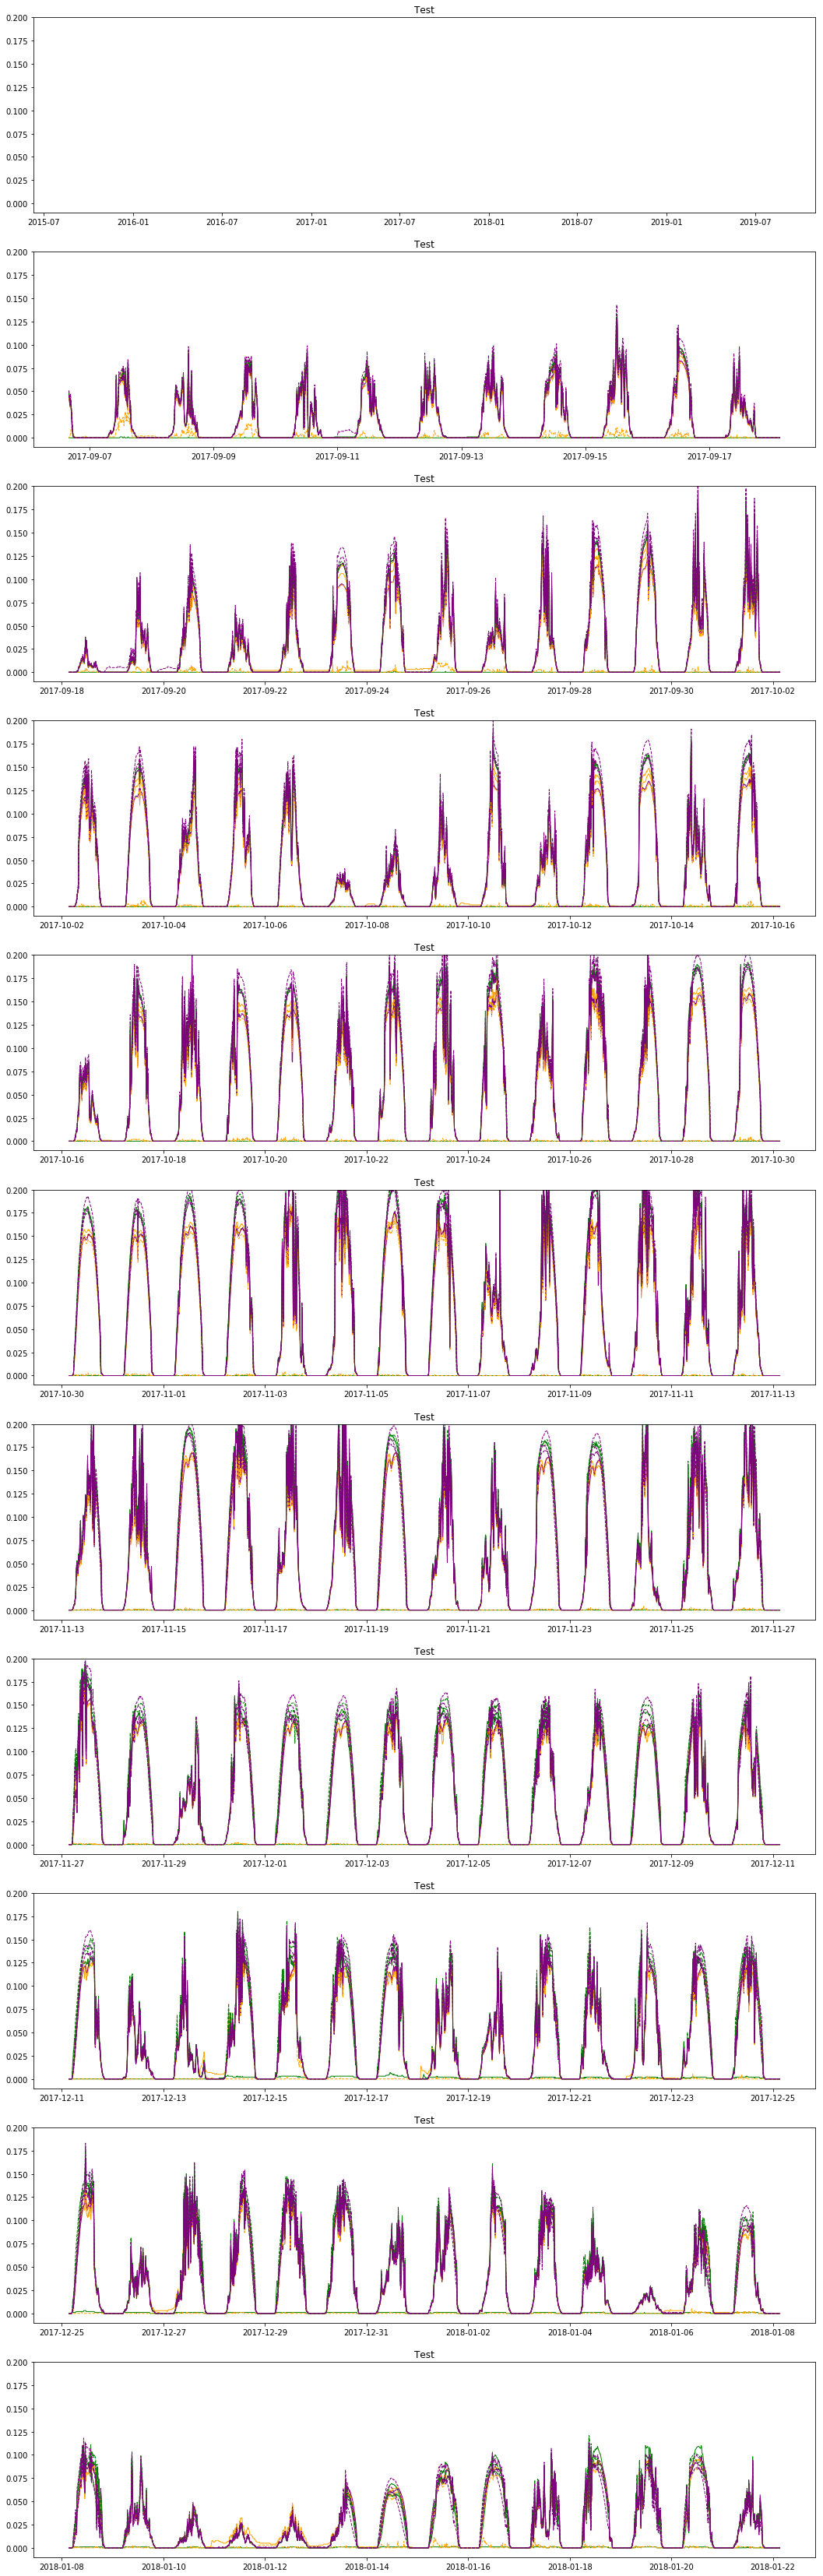

In [13]:
#Create a figure object
Fig = plt.figure(figsize=(18, 60))
MakeGraph(Data.ReflectedRadnMJ,0.2,-0.01)

## One sensor is returning zeros, need to null these values 

In [14]:
Data.loc[:,('ReflectedRadnMJ','Excess','320',slice(None),slice(None),slice(None),115)] = np.nan
Data.loc[:,('ReflectedRadnKW','Excess','320',slice(None),slice(None),slice(None),115)] = np.nan
Data.loc[:,('ReflectedRadnMJ','Normal','125',slice(None),slice(None),slice(None),116)] = np.nan
Data.loc[:,('ReflectedRadnKW','Normal','125',slice(None),slice(None),slice(None),116)] = np.nan

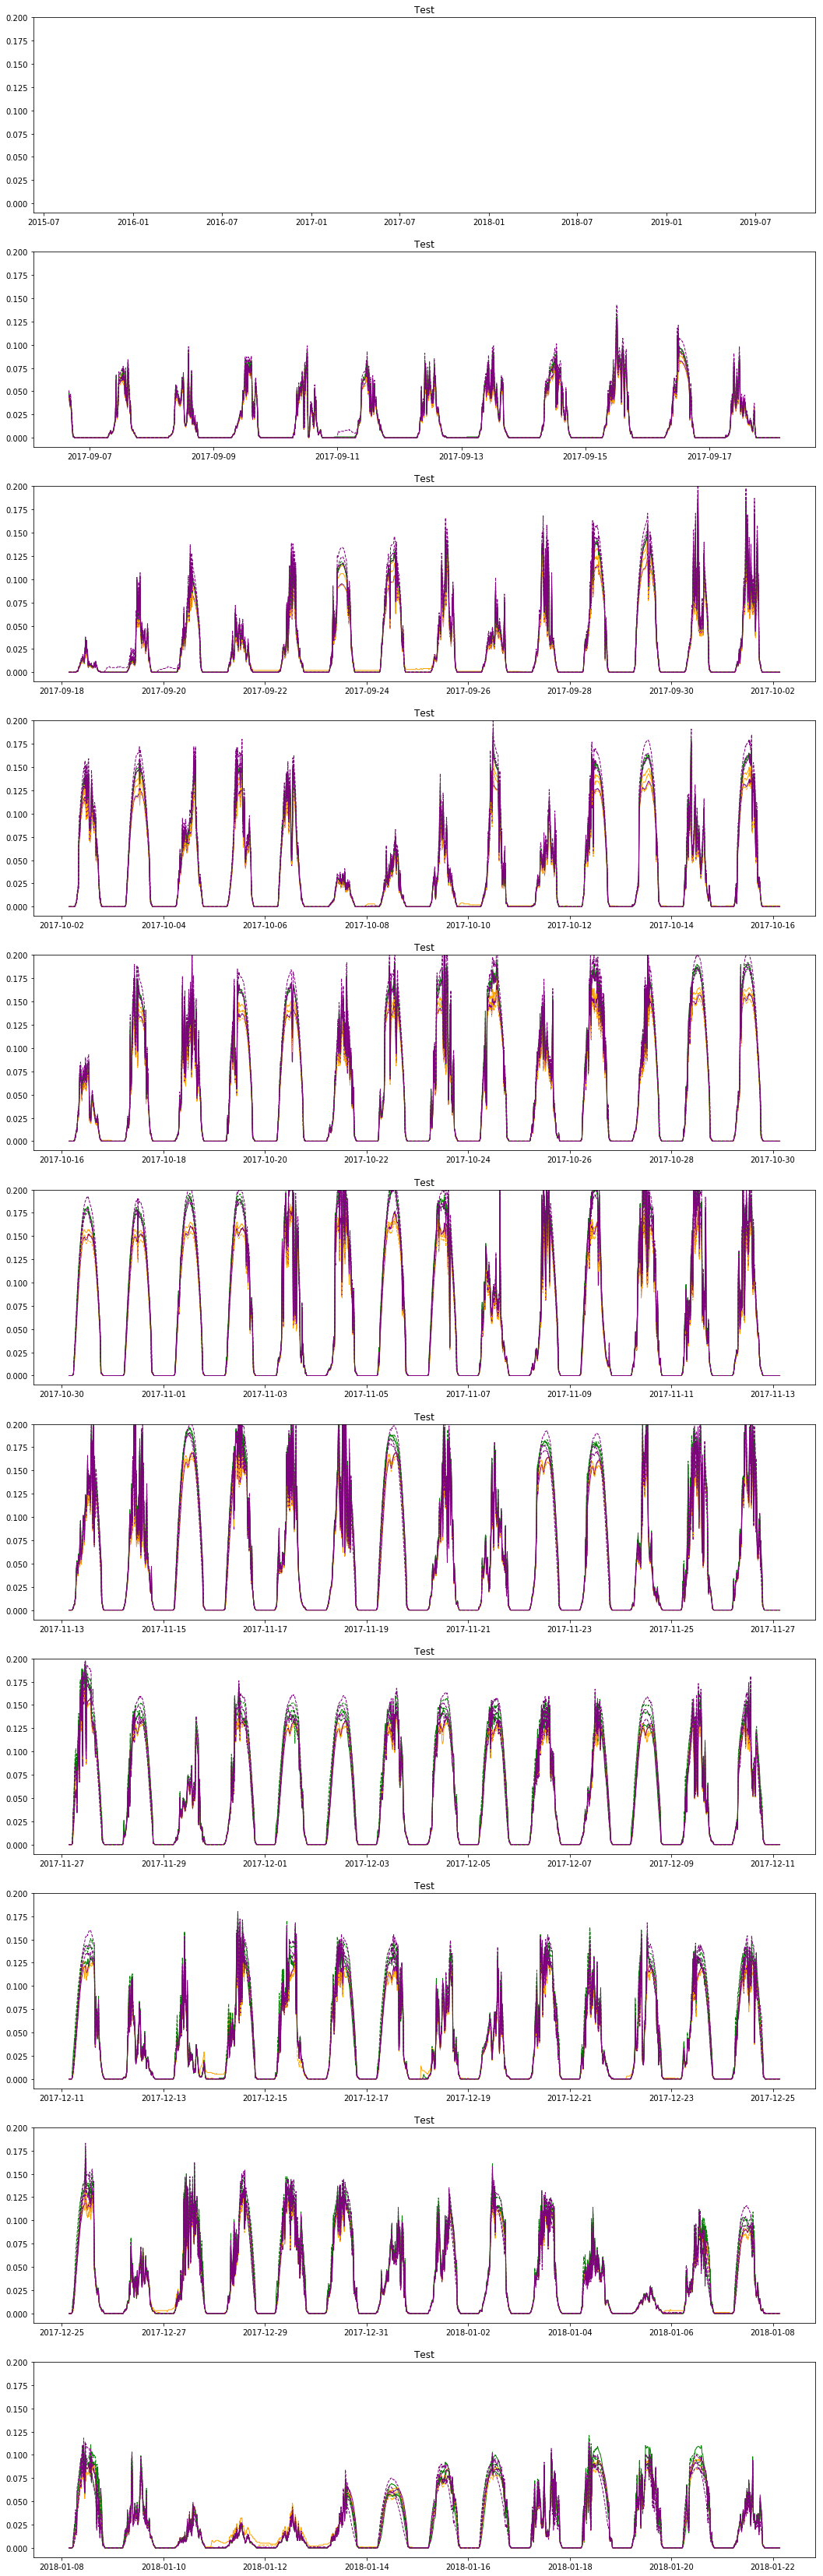

In [15]:
#Create a figure object
Fig = plt.figure(figsize=(18, 60))
MakeGraph(Data.ReflectedRadnMJ,0.2,-0.01)

## Now lets look at above canopy par

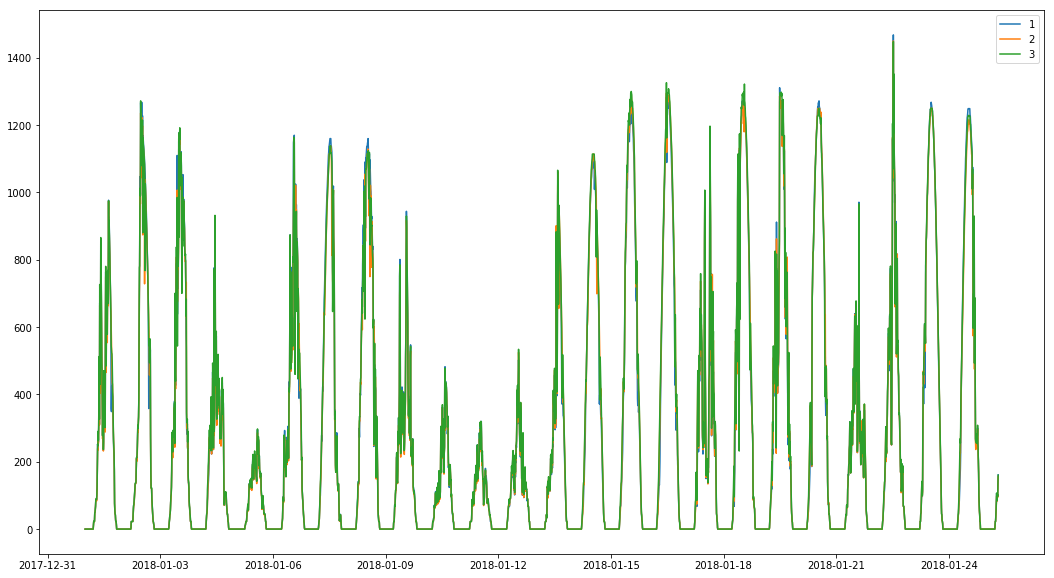

In [16]:
Figure = plt.figure(figsize=(18,10))
plt.plot(Data.loc['2018-01-01':,'AboveCanopyPAR1'],label='1')
plt.plot(Data.loc['2018-01-01':,'AboveCanopyPAR2'],label='2')
plt.plot(Data.loc['2018-01-01':,'AboveCanopyPAR3'],label='3')
plt.legend()

## all three are behaving well so lets take the mean

In [17]:
Data.loc[:,('AboveCanopyPAR','Expt','Expt','Expt','mmolPAR','Ave','Expt','Expt')] = Data.loc[:,['AboveCanopyPAR1','AboveCanopyPAR2','AboveCanopyPAR3']].mean(axis=1)

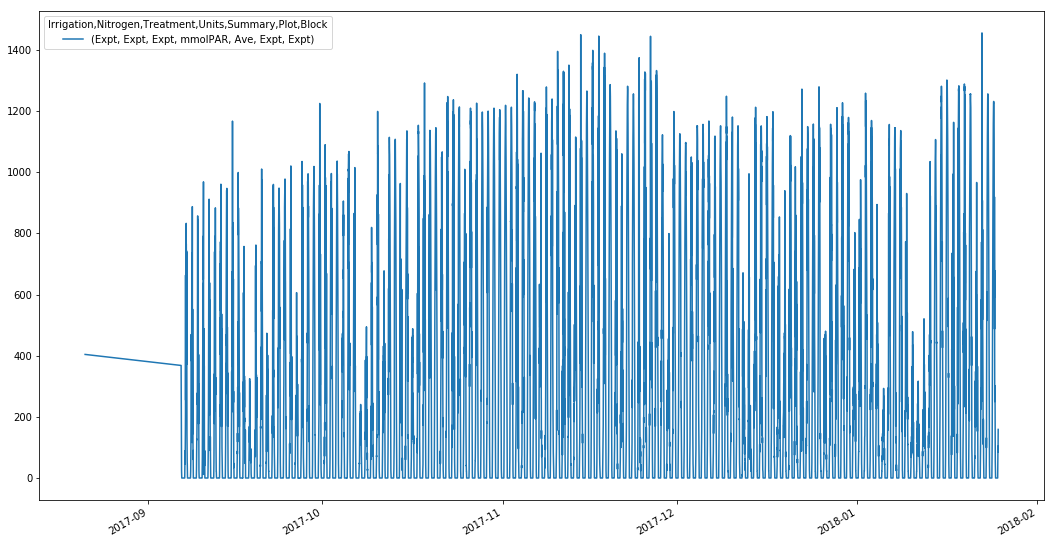

In [18]:
Data.AboveCanopyPAR.plot(figsize = (18,10))

In [19]:
Data.drop(columns = ['AboveCanopyPAR1','AboveCanopyPAR2','AboveCanopyPAR3'], level=0,inplace=True)

# Check Met Data.  Radiation first.

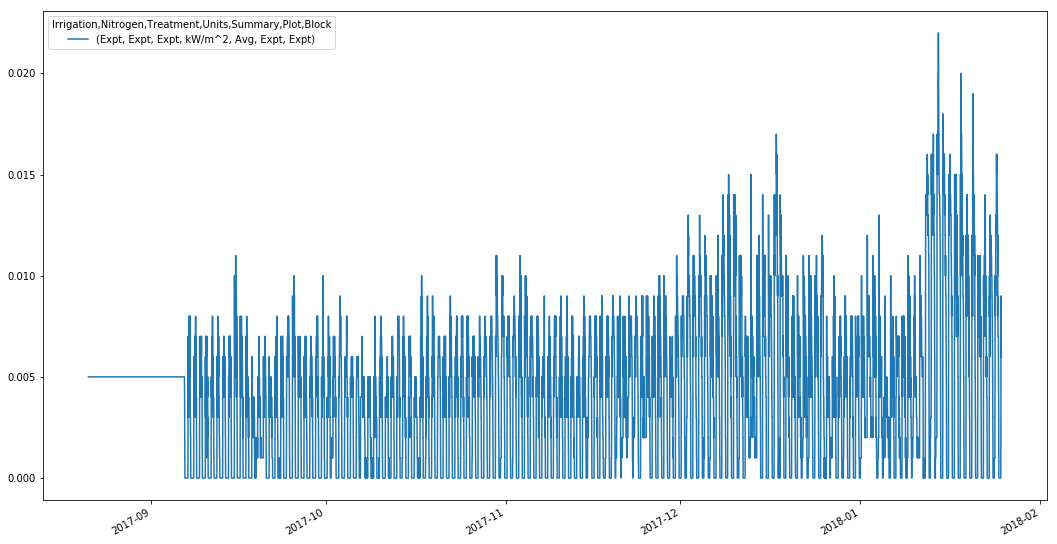

In [20]:
Data.IncomingRadnKW.plot(figsize = (18,10))

## Problem with Radiation sensor, Will Need to patch this with BroadFields data

In [21]:
BroadFieldsMet = pd.read_pickle('..\BroadFieldsMet.pkl')
BroadFieldsMet.drop_duplicates(inplace=True)
Data.loc[:,'IncomingRadnMJ'] = BroadFieldsMet.reindex(index = Data.index)['IncomingRadnMJ']
Data.loc[:,'IncomingRadnKW'] = (Data.loc[:,'IncomingRadnMJ'] * 1e6 /600/1000).values 

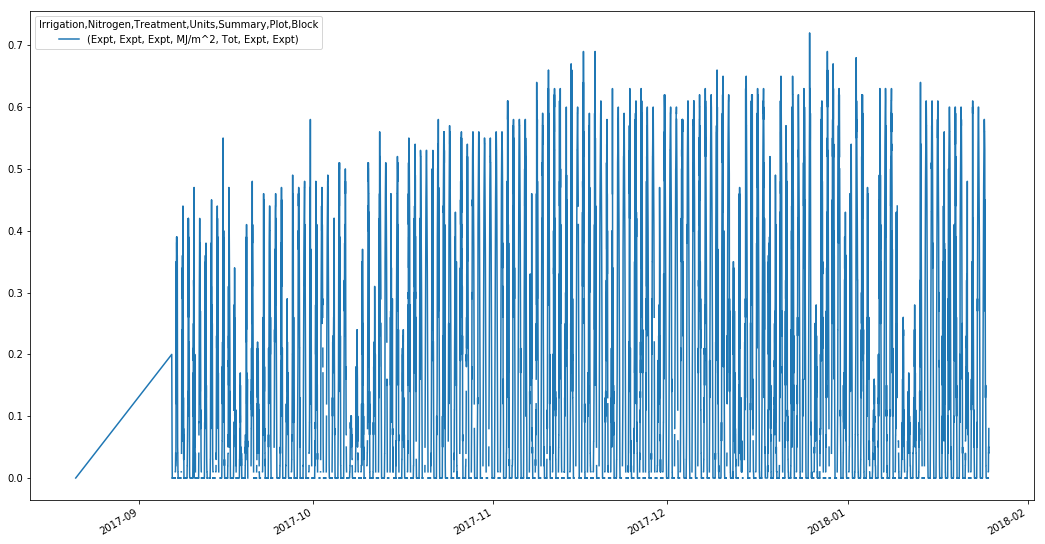

In [22]:
Data.IncomingRadnMJ.plot(figsize = (18,10))

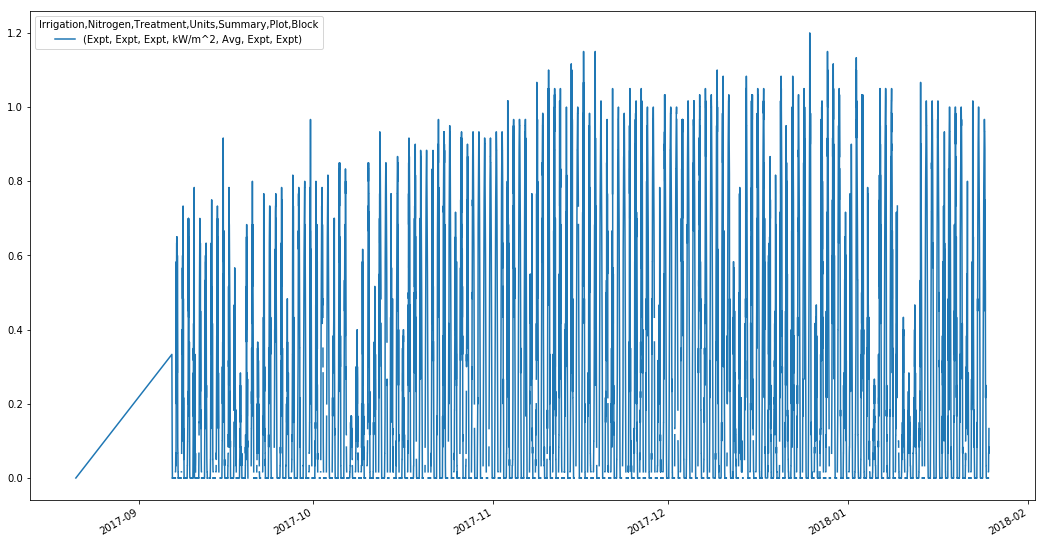

In [23]:
Data.IncomingRadnKW.plot(figsize = (18,10))

## Then Air Temperature

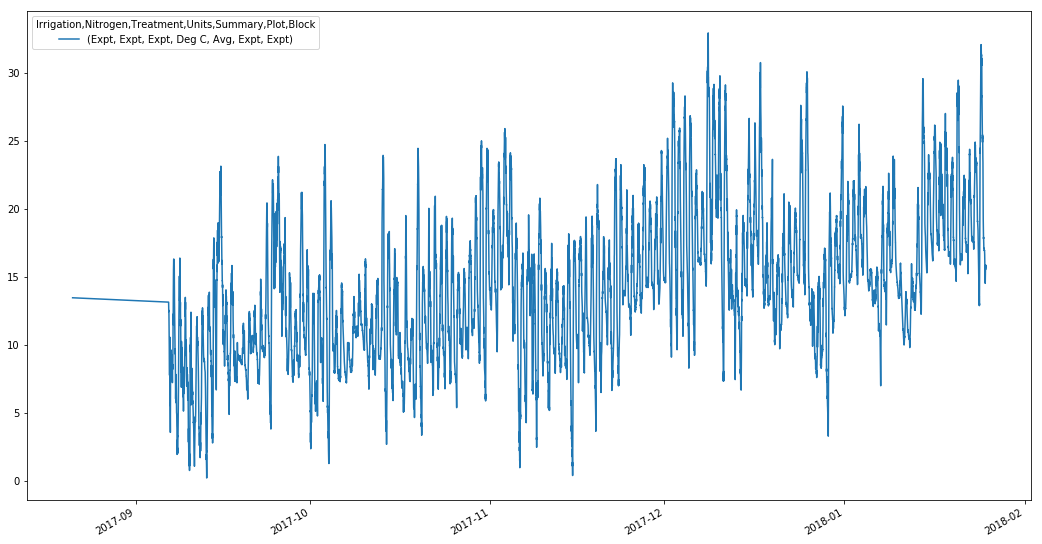

In [24]:
Data.AirTemperature.plot(figsize = (18,10))

## Check humidity

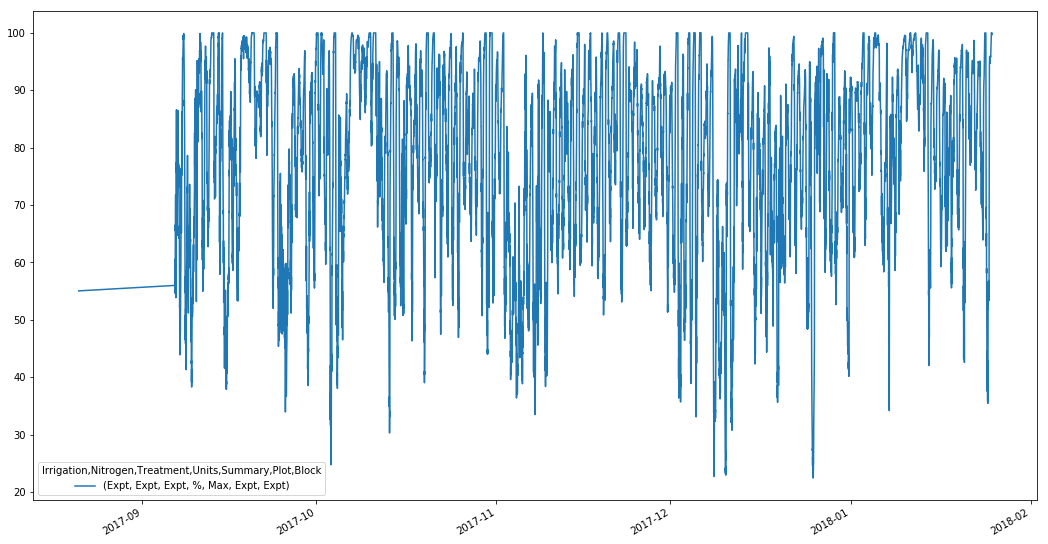

In [25]:
Data.RelativeHumidity.plot(figsize = (18,10))

## Check Wind

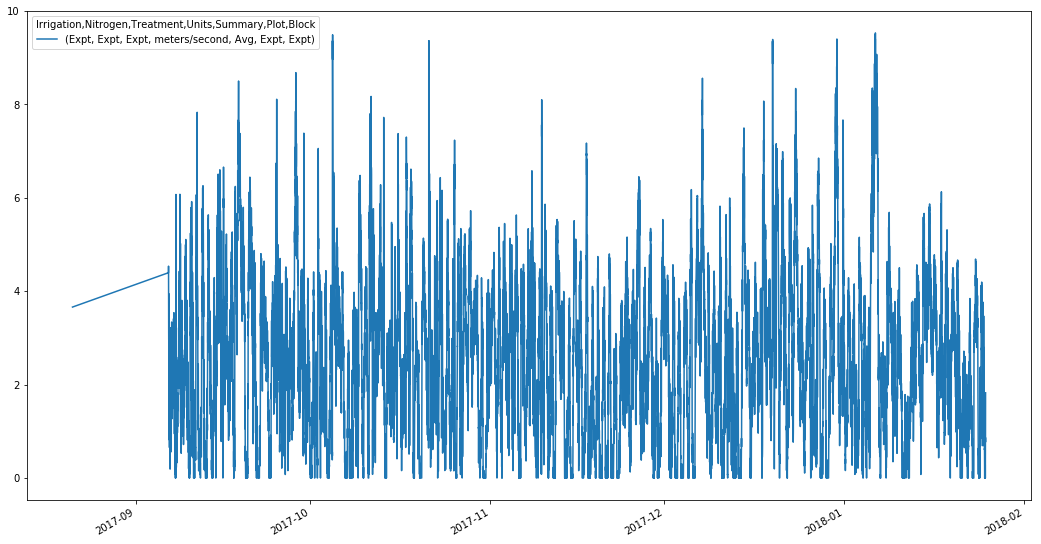

In [26]:
Data.Windspeed.plot(figsize = (18,10))

(0, 0.5)

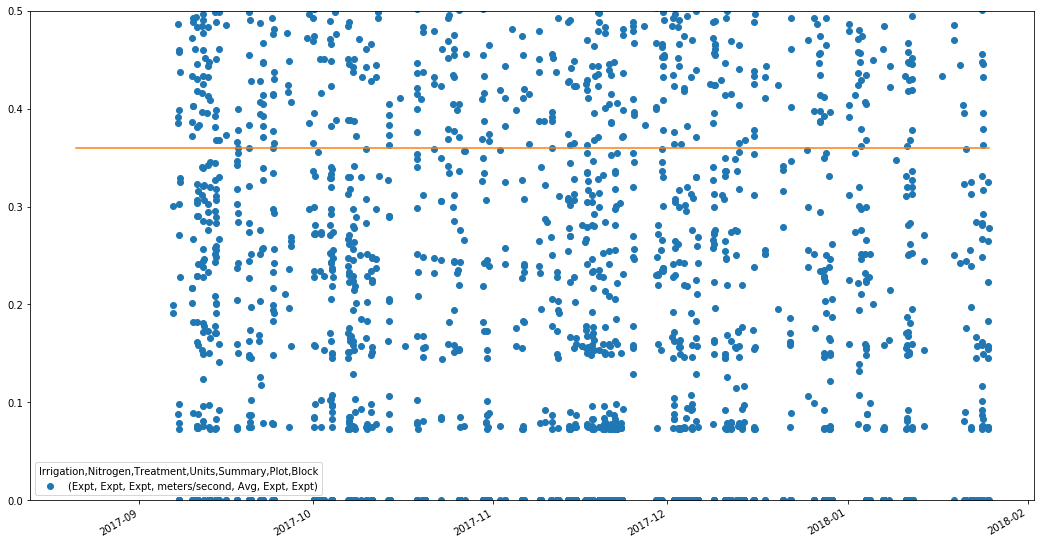

In [27]:
Data.Windspeed.plot(figsize=(18,10),style='o')
plt.plot([Data.index.min(),Data.index.max()],[0.36,0.36])
plt.ylim(0,0.5)

### For some reason data logger not zeroing windspeeds <0.36m/x so we need to enforce this

In [28]:
Data.Windspeed = Data.Windspeed.where(Data.Windspeed>0.36,0.0)

(0, 0.5)

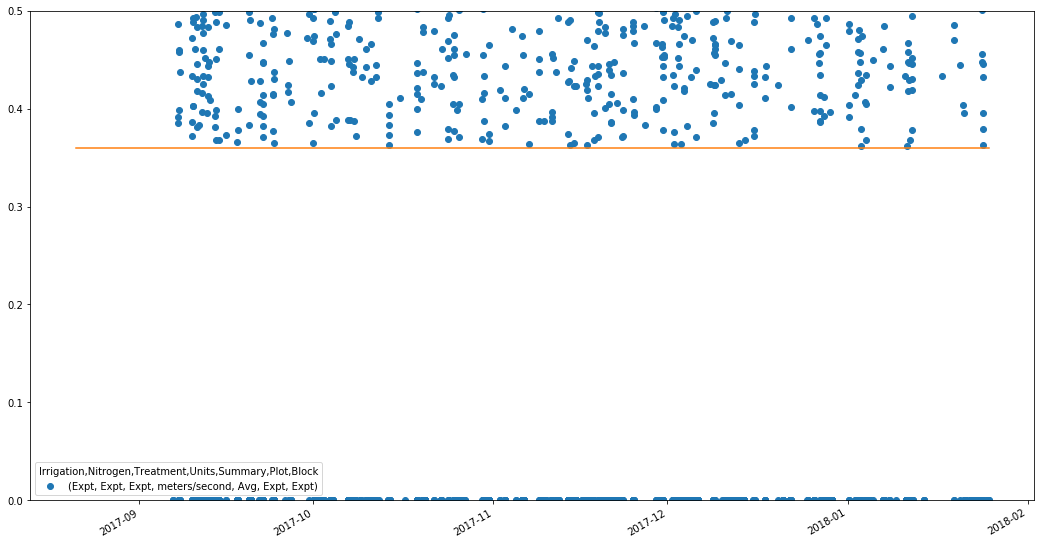

In [29]:
Data.Windspeed.plot(figsize=(18,10),style='o')
plt.plot([Data.index.min(),Data.index.max()],[0.36,0.36])
plt.ylim(0,0.5)

## Check Leaf Wettness

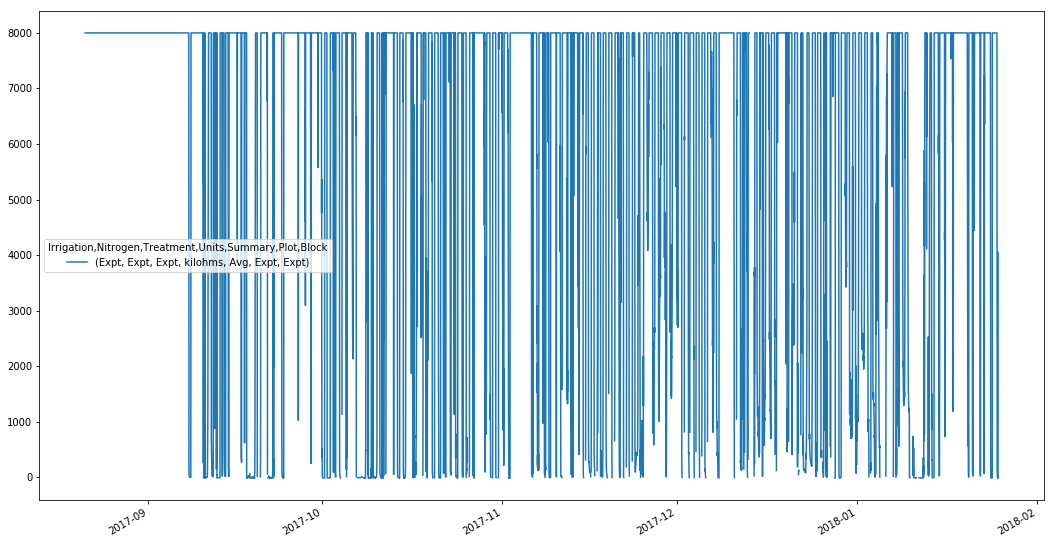

In [30]:
Data.Leafwetness.plot(figsize = (18,10))

# Now we have a clean data set lets pickle it

In [31]:
GH.SortFrame(Data)
Data.to_pickle('.\DataFrames\TempAndRadnCleaned.pkl')

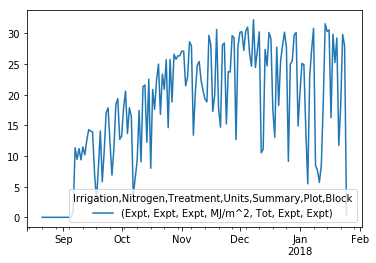

In [32]:
Data.IncomingRadnMJ.resample('d').sum().plot()